In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
import pandas as pd

In [3]:
methods = ["MMD", "MMD OCSVM Verify", "OCSVM"]
model_types = {"kernel=\'linear\'" : "linear", "SVR(":"non-linear", "LinearRegression" : "LReg"}
kernel_colors = {"linear" : "r", "non-linear" : "b", "LReg" : "o"}
colors = ["bo", "go", "ro", "co", "mo", "yo", "ko"]
direction_markers = [">", "<"]
marker_meaning = {">" : "forward", "<" : "backwards"}
normalized = {True : "-std", False: ""}
alpha_norm = {True : 1/3, False: 2/3}

In [4]:
def sort_similar_pairs(df):
    n_pairs =  int(df.shape[0]/2)
    
    for pair_index in range(n_pairs):
        pair = df.iloc[pair_index*2].copy()
        backwards_pair =  df.loc[(df.test_node == pair.model_node) & 
                                (df.model_node == pair.test_node)]

        if pair_index*2+1 != backwards_pair.index:
            misplaced_pair = df.loc[pair_index*2+1]
            df.iloc[backwards_pair.index] = misplaced_pair
            df.iloc[pair_index*2+1] = backwards_pair

        if pair.model_node > pair.test_node:
            df.iloc[pair_index*2] = backwards_pair
            df.iloc[pair_index*2+1] = pair

    similar_pairs = [str((pair[0], pair[1])) for pair in df.values]
    
    return similar_pairs

In [10]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

def plot_r2_discrpenacy(data):
    for experiment in range(1,4):
#         for method_index in range(3):
#             df = data.loc[(data.experiment==experiment)&(data.method==methods[method_index])]
        df = data.loc[(data.experiment==experiment)]
        unique_pairs_df = pd.DataFrame.from_records(np.unique(df[["model_node", "test_node"]].to_records(index=False)))     
        n_pairs =  int(unique_pairs_df.shape[0]/2)

        fig, axs = plt.subplots(nrows = n_pairs, ncols = 1, 
                                sharex="row", sharey='row',
                                figsize= (4, n_pairs * 3))

        similar_pairs = sort_similar_pairs(unique_pairs_df)
        pair_methods = {pair : [] for pair in similar_pairs[::2]}

        for row in df.itertuples(index=True, name='Pandas'):
            model_type = [model_types[m] for m in model_types if m in row.model][0]
            if model_type  in ["linear", "non-linear"]:
                pair = str((row.model_node, row.test_node))
                pair_index = similar_pairs.index(pair)
                direction = pair_index % 2
                
                if direction==0:
                    if row.method not in pair_methods[pair]:
                        pair_methods[pair].append(row.method)

                color = kernel_colors[model_type]
                x, y = row.discrepancy, row.score

                pair_row = int((pair_index - direction)/2)
                args = [color, alpha_norm[row.std], direction_markers[direction]]

                if n_pairs == 1:
                    axs.plot(x, y, args[0], alpha = args[1], marker = args[2])
                else:
                    axs[pair_row].plot(x, y, args[0], alpha = args[1], marker = args[2])

        fig.suptitle("Experiment "+ str(experiment), fontsize =15)
        fig.tight_layout(pad=3.0)
        

        if n_pairs==1:
            pair = similar_pairs[0]
            methods = ", ".join(pair_methods[pair])
            axs.set_title(f"{pair}-({methods})", fontsize=10)
            axs.set_xlabel("Discrepancy")
            axs.set_ylabel("Coefficient of Determination")
        else:
            for r in range(n_pairs):
                pair = similar_pairs[r*2]
                methods = ", ".join(pair_methods[pair])
                axs[r].set_title(f"{pair}-({methods})", fontsize=10)
                axs[r].set_xlabel("Discrepancy")
                axs[r].set_ylabel("Coefficient of Determination")

        d = df[["model_node", "test_node"]].values
        x = d[:,0]
        y = d[:,1]
        kernel_lines = [Line2D(x, y, c= kernel_colors[k], alpha = 2/3, linewidth=5) for k in ["linear","non-linear"]]
        std_lines = [Line2D(x, y, c= "r", alpha = alpha_norm[True], linewidth = 5)]
        direction_lines = [Line2D(x, y, c= "b", alpha = 2/3, marker = marker, linewidth = 0) for marker in direction_markers]

        lines = kernel_lines + std_lines + direction_lines

        plt.legend(lines, ["linear", "non-linear", "std", "forward", "backwards"])
        plt.show()

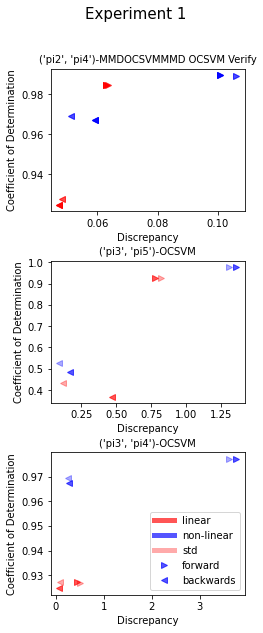

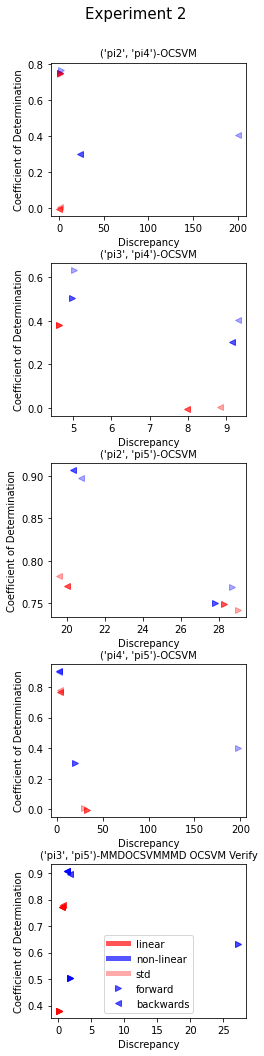

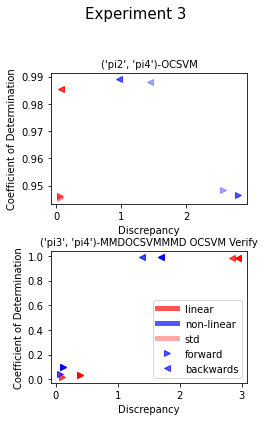

In [11]:
data = pd.read_csv(f"results/per method/sample_{1}.csv") 
plot_r2_discrpenacy(data)

In [80]:
samples = {}
for sample_id in range(1,5):
    sample = pd.read_csv(f"results/per method/sample_{i+1}.csv")
    experiment_data = {}
    for experiment in range(1,4):
        experiment_similar_pairs  = ""
        for method in methods:
            df = data.loc[(sample.experiment==experiment)&(data.method==method)]
            unique_pairs_df = pd.DataFrame.from_records(np.unique(df[["model_node", "test_node"]].to_records(index=False)))
            similar_pairs = sort_similar_pairs(unique_pairs_df)
            experiment_similar_pairs += str(similar_pairs[::2])
        experiment_data[experiment] = experiment_similar_pairs
    samples[f"sample_{sample_id}"] = experiment_data

In [83]:
samples["sample_1"] == samples["sample_2"] == samples["sample_3"] == samples["sample_4"]       

True